# Measuring importance of coefficients of OLS

$s^2 = \frac{y^TMy}{n -p} = \frac{y^T(y - X\hat{\beta})}{n -p}$

$s.e.(\hat{\beta_{j}}) = \sqrt{s^2(X^TX)^{-1}_{jj}}$

$t = \frac{\hat{\beta}}{s.e.(\hat{\beta})}$

$p = SF(|t|, n-p) * 2$

$c.i. = PPF((1 + confidence)/2, n-p)$


In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy import stats
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
import matplotlib.pyplot as plt

(20000L, 4L) (20000L,) (4L,)


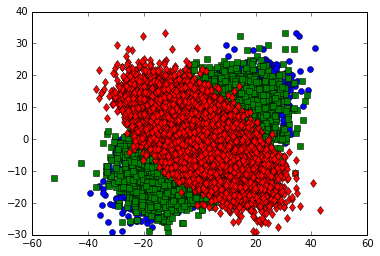

In [2]:
N = 20000
X = sm.add_constant(np.random.randn(N,3)*10)
w = np.array([0.25, 0.5, 0.3, -0.5])
y = np.dot(X,w) + np.random.randn(X.shape[0])
print X.shape, y.shape, w.shape
plt.plot(X[:, 1], y, "o", X[:, 2], y, "s", X[:, 3], y, "d")

In [3]:
model = sm.OLS(y, X)
res = model.fit()
print res.summary2()

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.983     
Dependent Variable: y                AIC:                56860.7399
Date:               2016-02-22 00:58 BIC:                56892.3538
No. Observations:   20000            Log-Likelihood:     -28426.   
Df Model:           3                F-statistic:        3.900e+05 
Df Residuals:       19996            Prob (F-statistic): 0.00      
R-squared:          0.983            Scale:              1.0050    
---------------------------------------------------------------------
           Coef.    Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      0.2313     0.0071     32.6241   0.0000    0.2174    0.2452
x1         0.4991     0.0007    703.1243   0.0000    0.4977    0.5005
x2         0.2994     0.0007    425.5916   0.0000    0.2980    0.3008
x3        -0.5010     0.0007   -711.3886   0.0000   -0

In [4]:
def R2(y, X, coeffs):
    y_hat = np.dot(X, coeffs)
    y_mean = np.mean(y)
    SST = np.sum((y-y_mean)**2)
    SSR = np.sum((y_hat - y_mean)**2)
    SSE = np.sum((y_hat - y)**2)
    #R_squared = SSR / SST
    R_squared = SSE / SST
    return 1- R_squared

In [5]:
R2(y, X, res.params)

0.98319694000573365

In [6]:
def se_coeff(y, X, coeffs):
    # Reference: https://en.wikipedia.org/wiki/Ordinary_least_squares#Finite_sample_properties
    s2 = np.dot(y, y - np.dot(X, coeffs)) / (X.shape[0] - X.shape[1]) # Calculate S-squared
    XX = np.diag(np.linalg.inv(np.dot(X.T, X))) # Calculate 
    return np.sqrt(s2*XX)

In [7]:
coeffs = res.params
N, K = X.shape
se = se_coeff(y, X, coeffs)
t = coeffs / se
p = stats.t.sf(np.abs(t), N - K)*2
ci = stats.t.ppf((1 + 0.95)/2, N-K)*se
pd.DataFrame(np.vstack((coeffs, se, t, p, coeffs - ci, coeffs + ci)).T, columns=["coeff", "S.E.", "t", "p-value", "ci-", "ci+"])


,coeff,S.E.,t,p-value,ci-,ci+
0,0.2313,0.0071,32.6241,0.0000,0.2174,0.2452
1,0.4991,0.0007,703.1243,0.0000,0.4977,0.5005
2,0.2994,0.0007,425.5916,0.0000,0.2980,0.3008
3,-0.5010,0.0007,-711.3886,0.0000,-0.5024,-0.4996


# Coefficient Significant for Logistic Regression

In [8]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

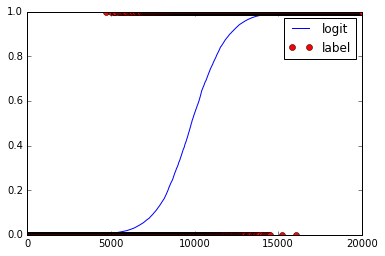

In [11]:
plt.clf()
y_sc = sigmoid(np.dot(X,w))
idx = np.argsort(y_sc)
plt.plot(y_sc[idx], "-b", label="logit")
y = stats.bernoulli.rvs(y_sc, size=y_sc.shape[0])
plt.plot(y[idx], "or", label="label")
plt.legend()

In [12]:
model = sm.Logit(y, X)
res = model.fit()
print res.summary2()
print w

Optimization terminated successfully.
         Current function value: 0.164233
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.763    
Dependent Variable: y                AIC:              6577.3345
Date:               2016-02-22 00:58 BIC:              6608.9484
No. Observations:   20000            Log-Likelihood:   -3284.7  
Df Model:           3                LL-Null:          -13861.  
Df Residuals:       19996            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const    0.2180     0.0317     6.8755   0.0000    0.1558    0.2801
x1       0.5046     0.0095    53.3732   0.0000    0.4861    0.5232
x2 

(array([ 7590.,   816.,   530.,   468.,   408.,   449.,   460.,   573.,
          825.,  7881.]),
 array([  2.97715082e-13,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

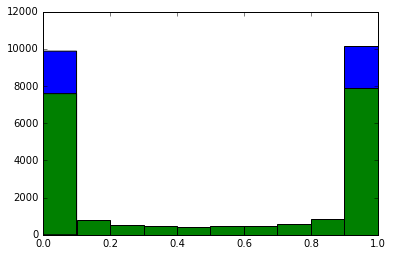

In [13]:
plt.hist(y)
plt.hist(y_sc)

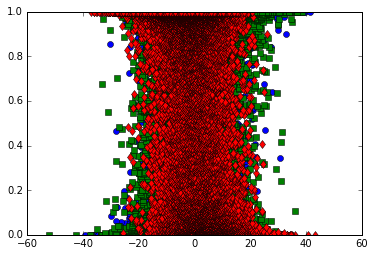

In [14]:
plt.plot(X[idx, 1], y_sc[idx], "o", X[idx, 2], y_sc[idx], "s", X[idx, 3], y_sc[idx], "d")

In [15]:
def se_coeff_logit(y, X, coeffs):
    # Reference: https://en.wikipedia.org/wiki/Ordinary_least_squares#Finite_sample_properties
    s2 = np.dot(y, y - sigmoid(np.dot(X, coeffs))) / (X.shape[0] - X.shape[1]) # Calculate S-squared
    XX = np.diag(np.linalg.inv(np.dot(X.T, X))) # Calculate 
    return np.sqrt(s2*XX)

In [16]:
coeffs = res.params
N, K = X.shape
se = se_coeff_logit(y, X, coeffs)
t = coeffs / se
p = stats.t.sf(np.abs(t), N - K)*2
ci = stats.t.ppf((1 + 0.95)/2, N-K)*se
pd.DataFrame(np.vstack((coeffs, se, t, p, coeffs - ci, coeffs + ci)).T, columns=["coeff", "S.E.", "t", "p-value", "ci-", "ci+"])


,coeff,S.E.,t,p-value,ci-,ci+
0,0.2180,0.0016,137.2274,0.0000,0.2148,0.2211
1,0.5046,0.0002,"3,173.6295",0.0000,0.5043,0.5049
2,0.2980,0.0002,"1,891.1343",0.0000,0.2977,0.2983
3,-0.5028,0.0002,"-3,187.5882",0.0000,-0.5031,-0.5025
